In [203]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymaid
import logging
import random
from graspologic.match import graph_match
from graspologic.simulations import er_np
from graspologic.utils import is_unweighted
from pkg.platy import _get_folder, load_connectome_normal_lcc_annotations, load_connectome_lcc_normal_adj, load_left_adj, load_right_adj, load_left_adj_labels_with_class_v2, load_right_adj_labels_with_class_v2, load_head_adj_labels_with_class_v2, load_pygidium_adj_labels_with_class_v2, load_0_adj, load_1_adj_labels_with_class_v2, load_2_adj_labels_with_class_v2, load_3_adj_labels_with_class_v2

Grab Nadine's pairs: these are the true pairs

In [204]:
folder = "/Users/kareefullah/Desktop/naomi-pairwise.xlsx"
true_df = pd.read_excel(folder, dtype=str)

#need to subset true_pairs for the pairs that have left and right entries in their row
true_pairs = true_df[["skid-ID LEFT", "skid-ID RIGHT"]]

#subset true_pairs to not include pairs of neurons that do not have a match
true_pairs = true_pairs[~true_pairs.isnull().any(axis=1)].reset_index()
left_true = list(true_pairs["skid-ID LEFT"])
right_true = list(true_pairs["skid-ID RIGHT"])
true_pairs

,index,skid-ID LEFT,skid-ID RIGHT
0,0,7501,25010
1,1,10536,26163
2,2,6743,23921
3,3,151847,27064
4,4,12115,27917
...,...,...,...
288,669,1326008,1359694
289,670,1717565,1330831
290,671,493317,1299058
291,672,1855933,111948


Load in the left and right adjacency matrices (each neuron in both adjacencies has an associated class label)

In [205]:
left_adj, _ = load_left_adj_labels_with_class_v2()
right_adj, _ = load_right_adj_labels_with_class_v2()

np_left_adj = np.array(left_adj)
np_right_adj = np.array(right_adj)

print(len(left_adj))
print(len(right_adj))

1226
1205


In [206]:
left_skids = left_adj.index
right_skids = right_adj.index

In [207]:
ind_left_list = []
ind_right_list = []
n_iters = 50
n_iters_rand = 100

Run graph matching without any initialization of the matrices

In [208]:
#WHOLE, DEFAULT, OPT
for i in range(n_iters):
    ind_left, ind_right, score, misc = graph_match(np_left_adj, np_right_adj)
    ind_left_list.append(ind_left)
    ind_right_list.append(ind_right)

In [209]:
#score from WHOLE DEFAULT OPT
score

14653.0

(<AxesSubplot:>,
 <mpl_toolkits.axes_grid1.axes_divider.AxesDivider at 0x160ff6580>)

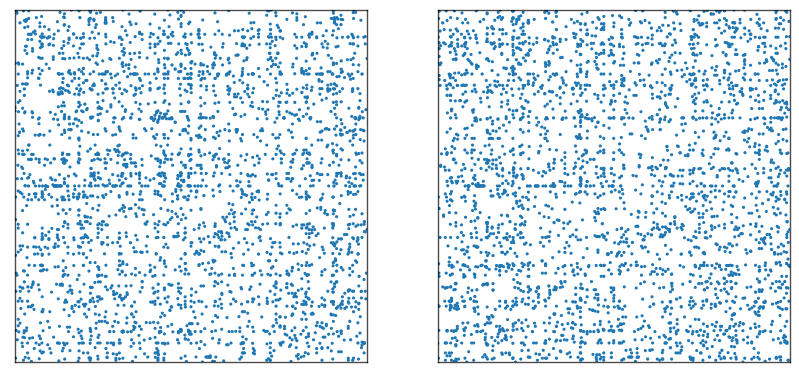

In [210]:
import seaborn as sns
from graspologic.plot import adjplot

fig, axs = plt.subplots(1,2,figsize=(10, 5))
adjplot(np_left_adj[ind_left_list[0]][:, ind_left_list[0]], plot_type='scattermap', ax=axs[0])
adjplot(np_right_adj[ind_right_list[0]][:, ind_right_list[0]], plot_type='scattermap', ax=axs[1])

Permute the skids based on graph matching, this gives us the pairs from graph matching

In [211]:
matched_pairs_list = []

for i in range(n_iters):
    left_matched_skids = left_skids[ind_left_list[i]]
    right_matched_skids = right_skids[ind_right_list[i]]

    #make dataframe for the matched pairs
    matched_pairs = pd.DataFrame(list(zip(left_matched_skids, right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    matched_pairs_list.append(matched_pairs)

Calculating the accuracy of how graph matching did (compare our pairs to Nadine's pairs)

In [212]:
accuracy_list = []
df_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    df = pd.merge(true_pairs, matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')
    df_list.append(df)
    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = df[df.duplicated("skid-ID LEFT")]
    duplicate_R = df[df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    accuracy = num/den
    accuracy_list.append(accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.011655011655011656
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.01809954751131222
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.013761467889908258
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.011467889908256881
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.02054794520547945
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.016241299303944315
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.014084507042253521
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.018433179723502304
The proportion of left right pairs from gr

In [213]:
df1 = pd.DataFrame({'L': [1, 2, 3, 4, 5, 6, 7, 8], 'R': ["a", "b", "c", "d", "e", "f", "g", "h"]})
df2 = pd.DataFrame({'L': [1, 3, 12, 9, 10, 11, 2, 4, 6, 5], 'R': ["a", "d", "h", "r", "w", "u", "b", "d", "q", "c"]})
print(df1)
print(df2)

   L  R
0  1  a
1  2  b
2  3  c
3  4  d
4  5  e
5  6  f
6  7  g
7  8  h
    L  R
0   1  a
1   3  d
2  12  h
3   9  r
4  10  w
5  11  u
6   2  b
7   4  d
8   6  q
9   5  c


In [214]:
new_df = pd.merge(df1, df2, on=["L", 'R'], how="outer", indicator="exist")
test_num = new_df["exist"].value_counts()["both"]
duplicate_L = new_df[new_df.duplicated(['L'])]
duplicate_R = new_df[new_df.duplicated(['R'])]
new_df

,L,R,exist
0,1,a,both
1,2,b,both
2,3,c,left_only
3,4,d,both
4,5,e,left_only
5,6,f,left_only
6,7,g,left_only
7,8,h,left_only
8,3,d,right_only
9,12,h,right_only


In [215]:
print(duplicate_L)
print(duplicate_R)
duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["L", "R"], how="outer", indicator="Exist")
acc = test_num / (test_num + len(duplicate_df))
print(acc)
duplicate_df

    L  R       exist
8   3  d  right_only
13  6  q  right_only
14  5  c  right_only
     L  R       exist
8    3  d  right_only
9   12  h  right_only
14   5  c  right_only
0.42857142857142855


,L,R,exist_x,exist_y,Exist
0,3,d,right_only,right_only,both
1,6,q,right_only,NaN,left_only
2,5,c,right_only,right_only,both
3,12,h,NaN,right_only,right_only


Calculate the norm of the difference of the two adjacencies after permuting the skids

In [216]:
diff_matched_norm_list = []
for i in range(n_iters):
    #norms of matched adjs
    #subset and permute the adjacencies by their indices from matching
    np_left_adj_matched = np_left_adj[np.ix_(ind_left_list[i], ind_left_list[i])]
    np_right_adj_matched = np_right_adj[np.ix_(ind_right_list[i], ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_diff_adj_matched = np_left_adj_matched - np_right_adj_matched
    diff_matched_norm = np.linalg.norm(np_diff_adj_matched)
    diff_matched_norm_list.append(diff_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {diff_matched_norm}")

In [217]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_left_adj), size=len(np_right_adj), replace=False)
    np_left_adj_rand = np_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_right_adj), size=len(np_right_adj), replace=False)
    np_right_adj_rand = np_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_diff_adj_rand = np_left_adj_rand - np_right_adj_rand
    diff_rand_norm = np.linalg.norm(np_diff_adj_rand)
    rand_norms_whole.append(diff_rand_norm)


In [218]:
accuracy_mean = np.average(accuracy_list)
norm_mean = np.average(diff_matched_norm_list)

Plot histogram showing how our norm compares to the norms after random permutations of the matrices

Text(0.5, 1.0, 'Norm of difference of matched vs random whole adjacencies (norm: 153.72), (accuracy: 0.02)')

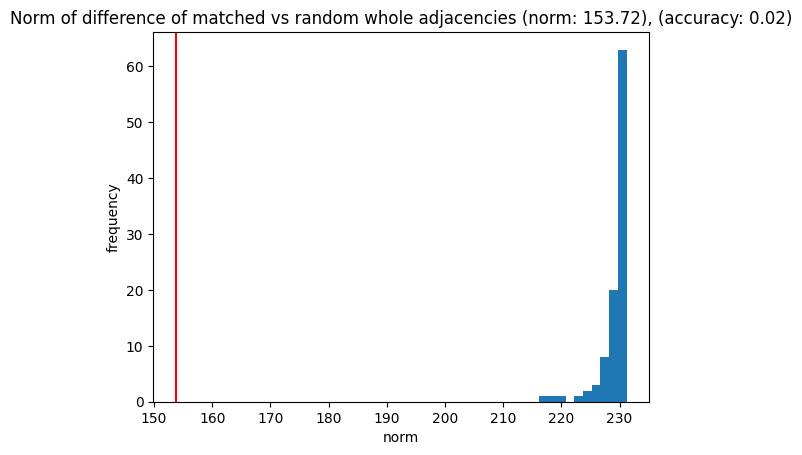

In [219]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole)
ax.axvline(norm_mean, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(norm_mean, accuracy_mean))

Look at morphologies of neurons that were paired correctly, 5 morphologies of neurons that were paired correctly in only Nadine's, and 5 morphologies of neurons that were paired in ours

In [220]:
rm = pymaid.CatmaidInstance(
    server="https://catmaid.jekelylab.ex.ac.uk/#",
    project_id=11,
    api_token=None,
    http_user=None,
    http_password=None,
)
logging.getLogger("pymaid").setLevel(logging.WARNING)
pymaid.clear_cache()

In [221]:
#look at correct morphologies
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list_both = []
neuron_list_nadine = []
neuron_list_ours = []

for ind, row in df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]

    #when the pair exists in both our list and Nadine's list
    if(row["Exist"] == "both"):
        neuron_list_both.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in Nadine's list only
    elif(row["Exist"] == "left_only" and len(neuron_list_nadine)<=5):
        neuron_list_nadine.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])
    
    #when the pair exists in our list only
    elif(row["Exist"] == "right_only" and len(neuron_list_ours)<=5):
        neuron_list_ours.append([pymaid.get_neuron(neurons), neurons[0], neurons[1]])

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

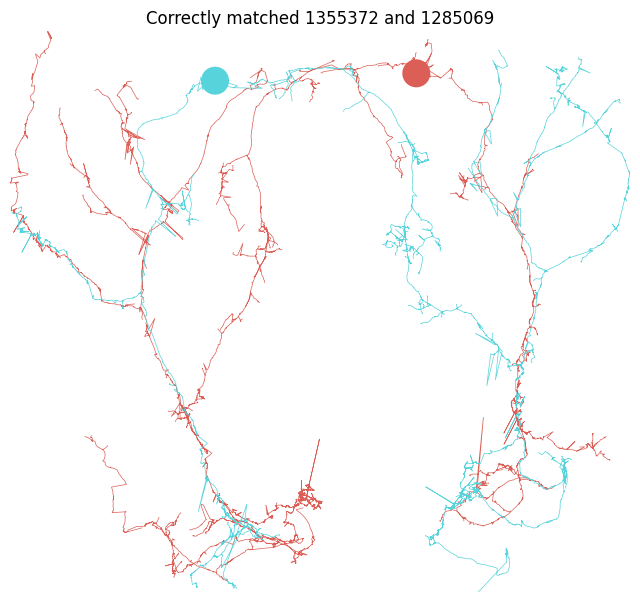

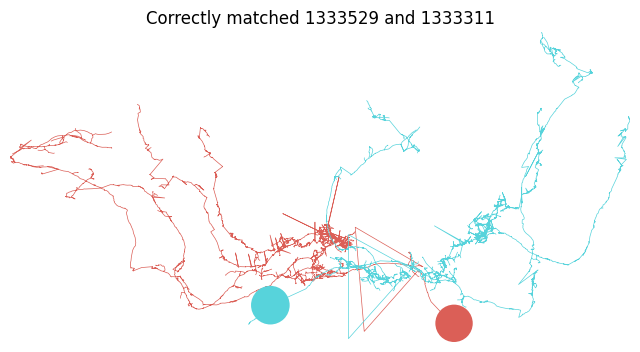

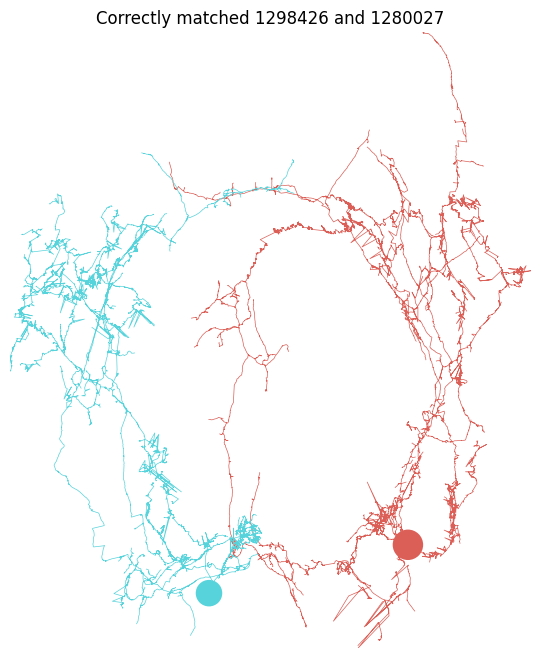

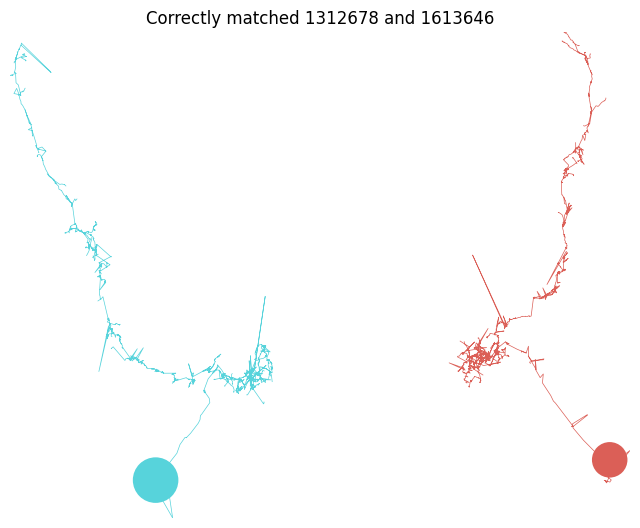

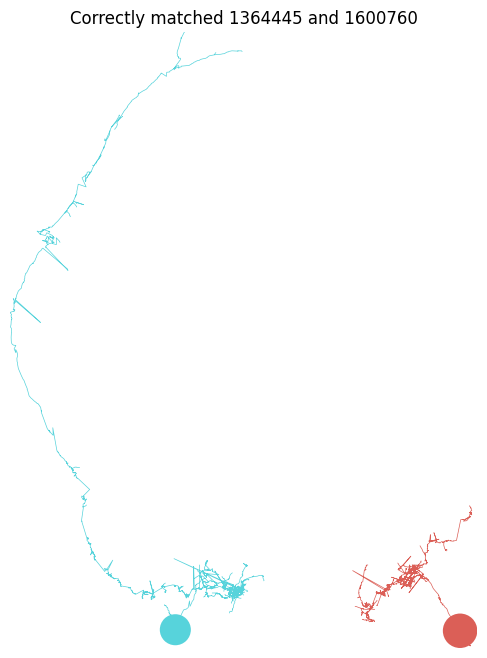

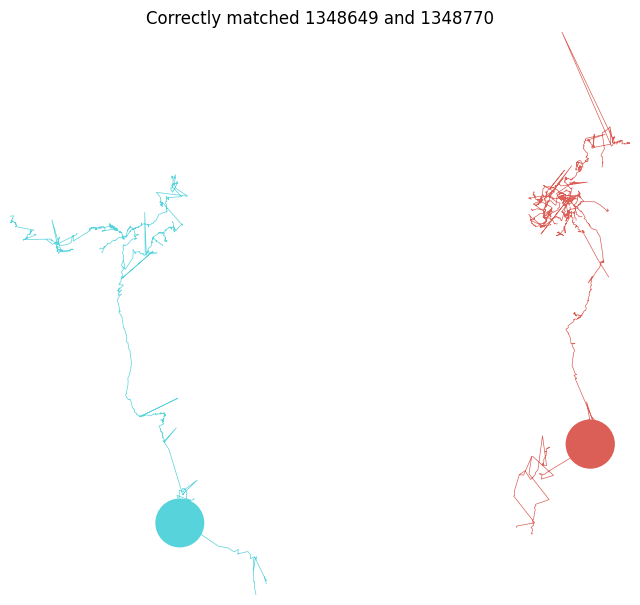

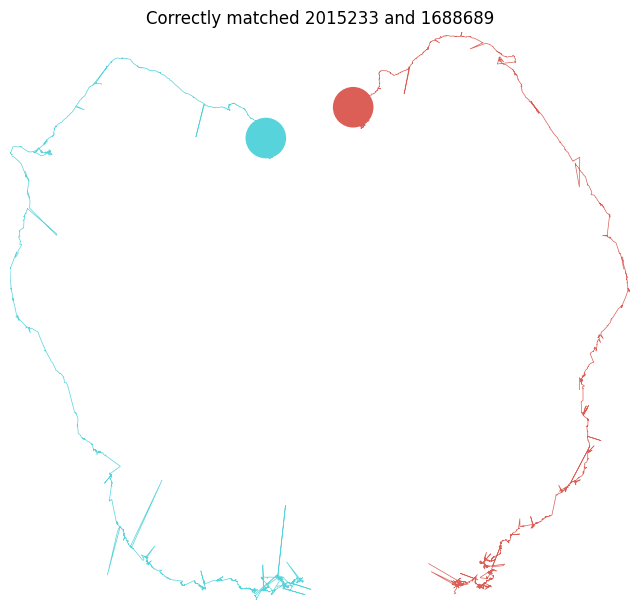

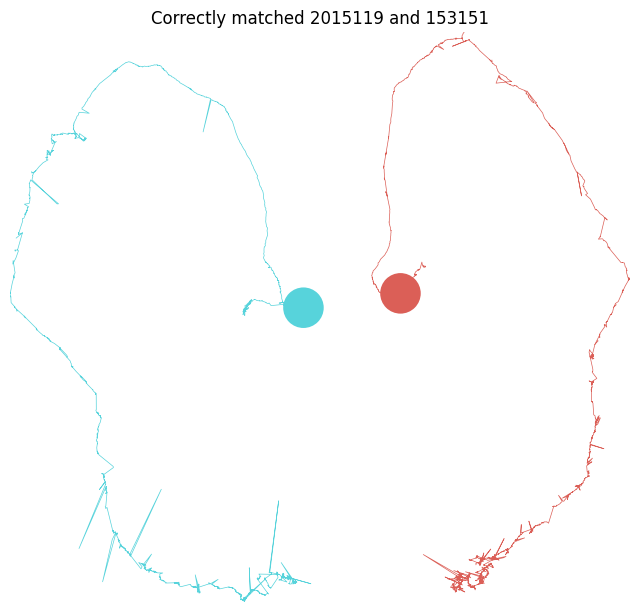

In [222]:
#visualize correctly matched neurons
for i in range(len(neuron_list_both)):
    fig, ax = navis.plot2d(neuron_list_both[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_both[i][1]
    right = neuron_list_both[i][2]
    ax.set_title(f"Correctly matched {left} and {right}")

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

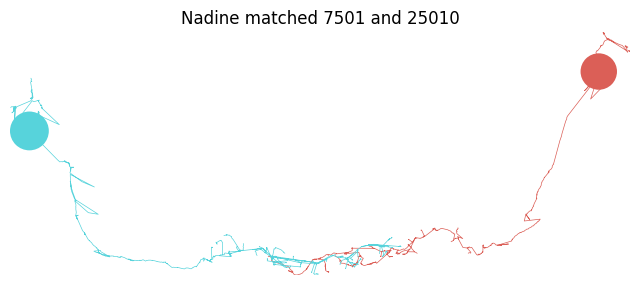

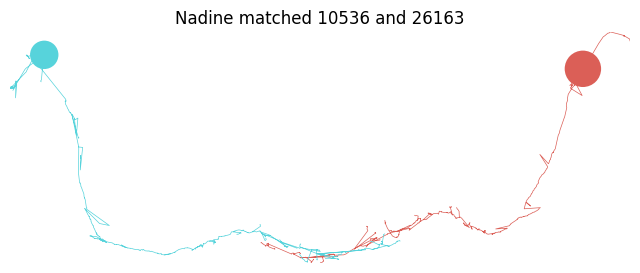

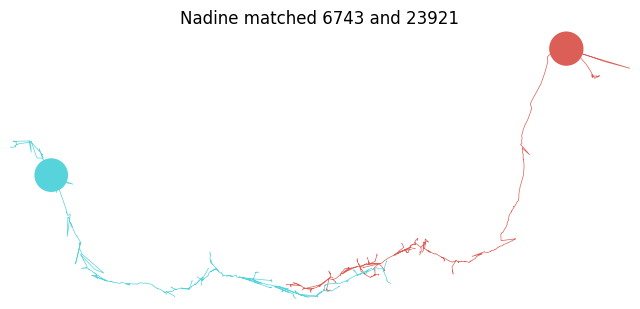

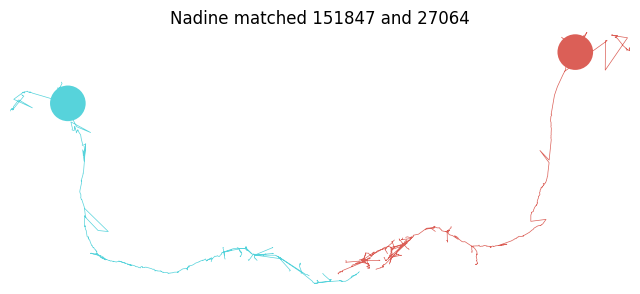

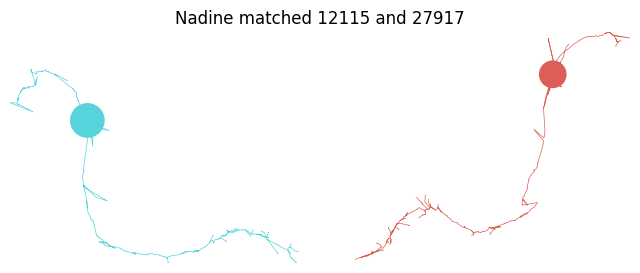

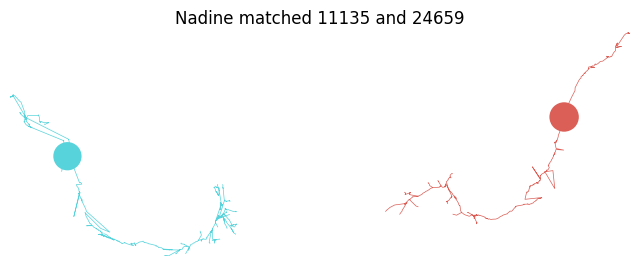

In [223]:
#visualize neurons that nadines matched that was not in ours
for i in range(len(neuron_list_nadine)):
    fig, ax = navis.plot2d(neuron_list_nadine[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_nadine[i][1]
    right = neuron_list_nadine[i][2]
    ax.set_title(f"Nadine matched {left} and {right}")

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

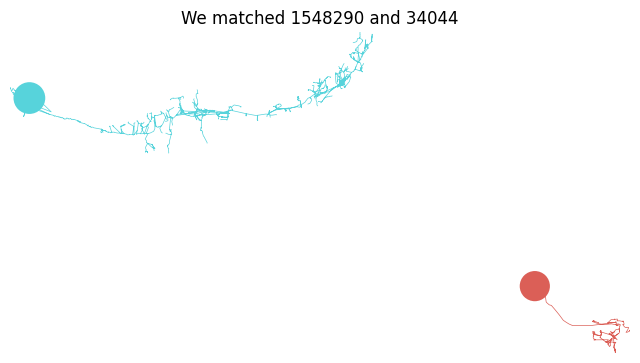

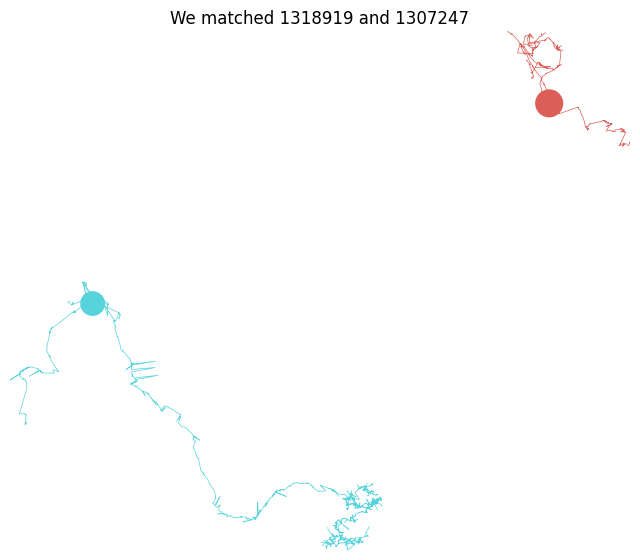

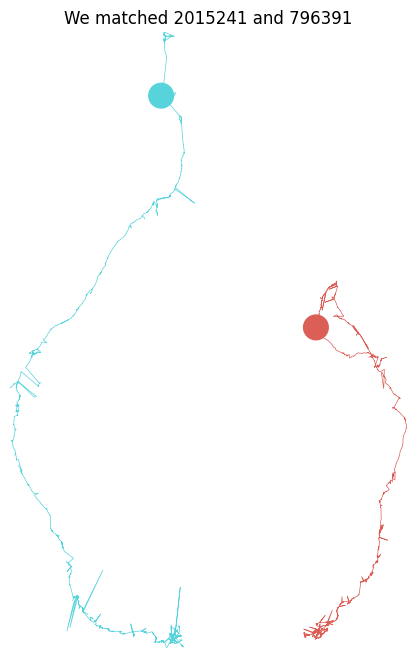

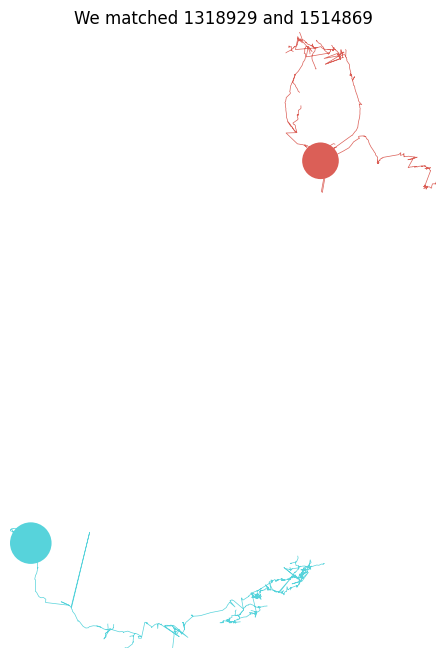

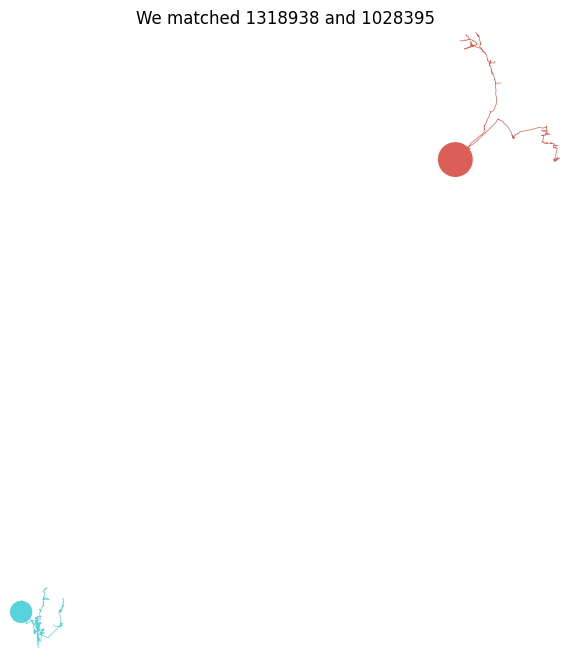

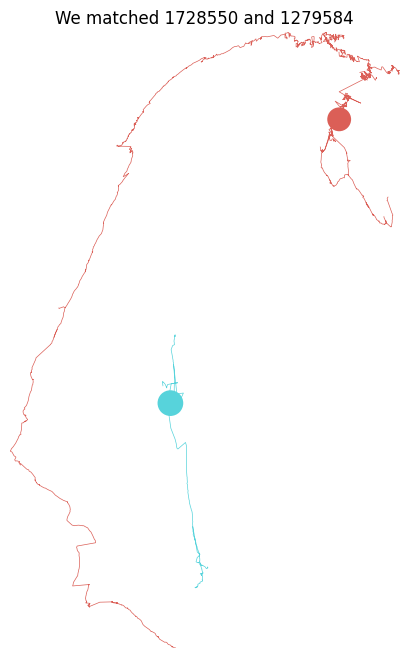

In [224]:
#visualize neurons that we matched that nadine did not
for i in range(len(neuron_list_ours)):
    fig, ax = navis.plot2d(neuron_list_ours[i][0], method='2d', view=('x', '-y'))
    left = neuron_list_ours[i][1]
    right = neuron_list_ours[i][2]
    ax.set_title(f"We matched {left} and {right}")

Do all the same analyses, but run on the subgraph (from our total list of left and right neurons, use the subsets of the neurons that exist in true pairs)

In [225]:
sub_left_skids = [skid for skid in left_skids if skid in left_true]
sub_right_skids = [skid for skid in right_skids if skid in right_true]

pd_sub_left_skids = pd.Series(sub_left_skids)
pd_sub_right_skids = pd.Series(sub_right_skids)

print(len(sub_left_skids))
print(len(sub_right_skids))

266
259


In [226]:
sub_left_adj = pymaid.adjacency_matrix(sub_left_skids)
sub_right_adj = pymaid.adjacency_matrix(sub_right_skids)

np_sub_left_adj = np.array(sub_left_adj)
np_sub_right_adj = np.array(sub_right_adj)

In [227]:
sub_ind_left_list = []
sub_ind_right_list = []

Run graph matching without any initialization

In [228]:
#SUB, DEFAULT, OPT
for i in range(n_iters):
    sub_ind_left, sub_ind_right, sub_score, sub_misc = graph_match(np_sub_left_adj, np_sub_right_adj)
    sub_ind_left_list.append(sub_ind_left)
    sub_ind_right_list.append(sub_ind_right)

In [229]:
#Score from SUB, DEFAULT, OPT
sub_score

5140.0

Permute our lists of skids based on the results of graph matching

In [230]:
sub_matched_pairs_list = []
for i in range(n_iters):
    sub_left_matched_skids = pd_sub_left_skids[sub_ind_left_list[i]]
    sub_right_matched_skids = pd_sub_right_skids[sub_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_matched_pairs = pd.DataFrame(list(zip(sub_left_matched_skids, sub_right_matched_skids)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_matched_pairs_list.append(sub_matched_pairs)

Calculate the accuracy on our subgraphs after graph matching without initialization

In [231]:
sub_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_df = pd.merge(true_pairs, sub_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    sub_num = sub_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_df[sub_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_df[sub_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    sub_den = len(duplicate_df) + sub_num
    accuracy = sub_num/sub_den
    sub_matched_accuracy_list.append(accuracy)

    #print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(sub_num/sub_den))

Collect the neurons that were correctly matched from graph matching

In [232]:
correct_sub_df = sub_df.loc[sub_df["Exist"] == "both"]
correct_sub_df = correct_sub_df.reset_index()
correct_sub_df

,level_0,index,skid-ID LEFT,skid-ID RIGHT,Exist
0,43,63.0,1054945,1304968,both
1,45,65.0,45548,190983,both
2,49,69.0,1075718,1077309,both
3,62,110.0,167671,57341,both
4,77,160.0,386671,161743,both
5,78,161.0,1298426,1280027,both
6,84,168.0,1295517,715837,both
7,95,205.0,1729648,1307524,both
8,106,227.0,1678918,369396,both
9,110,244.0,1365661,1321475,both


Visualize the correctly matched neurons

In [233]:
import navis

#make list of CatmaidNeuronList for each pair of neurons
neuron_list = []
for ind, row in correct_sub_df.iterrows():
    neurons = [row["skid-ID LEFT"], row["skid-ID RIGHT"]]
    neuron_list.append(pymaid.get_neuron(neurons))

neuron_list

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

Fetch neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Make nrn:   0%|          | 0/2 [00:00<?, ?it/s]

[<class 'pymaid.core.CatmaidNeuronList'> containing 2 neurons (73.4KiB)
             type        name skeleton_id  n_nodes  n_connectors  n_branches  \
 0  CatmaidNeuron  INpreMN_1l     1054945     1247            38          70   
 1  CatmaidNeuron  INpreMN_1r     1304968     1037            29          60   
 
    n_leafs  cable_length       soma        units  
 0       82   192914.8125  [1055894]  1 nanometer  
 1       67   162056.8750  [1466707]  1 nanometer  ,
 <class 'pymaid.core.CatmaidNeuronList'> containing 2 neurons (82.6KiB)
             type        name skeleton_id  n_nodes  n_connectors  n_branches  \
 0  CatmaidNeuron  INpreMN_3l       45548     1084            28          57   
 1  CatmaidNeuron  INpreMN_3r      190983     1508            24          60   
 
    n_leafs  cable_length      soma        units  
 0       66   226916.0625  [659780]  1 nanometer  
 1       70   230932.5000  [211116]  1 nanometer  ,
 <class 'pymaid.core.CatmaidNeuronList'> containing 2 neurons

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/kareefullah/Library/Caches/pypoetry/virtualenvs/platy-data-EVeqgmAk-py3.9/lib/python3.9/site-packages/navis/plotting/dd.py:372: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=kwargs.get('figsize', (8, 8)))


Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

Plot neurons:   0%|          | 0/2 [00:00<?, ?it/s]

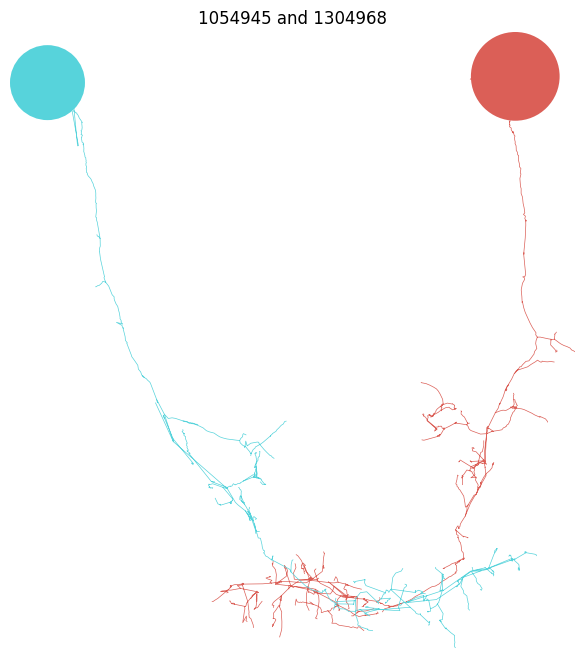

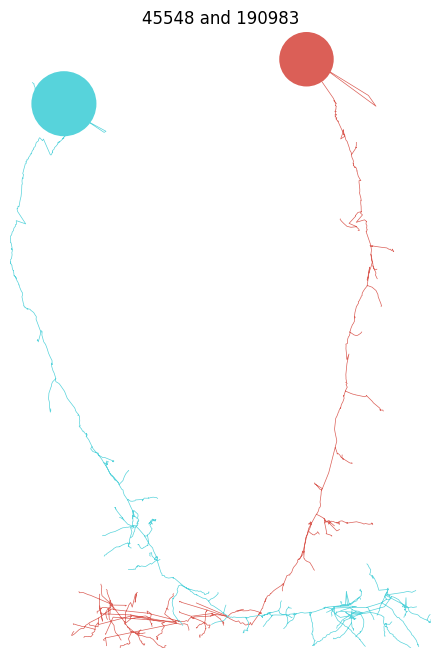

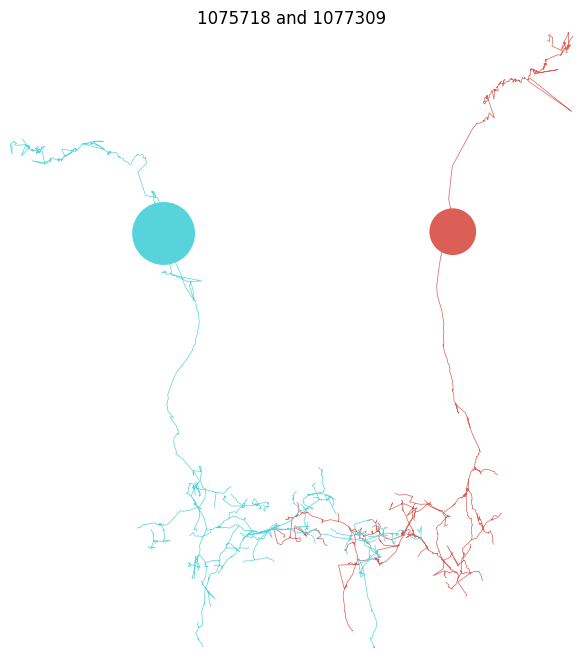

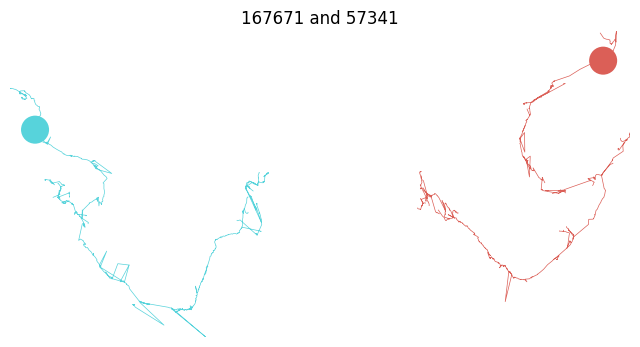

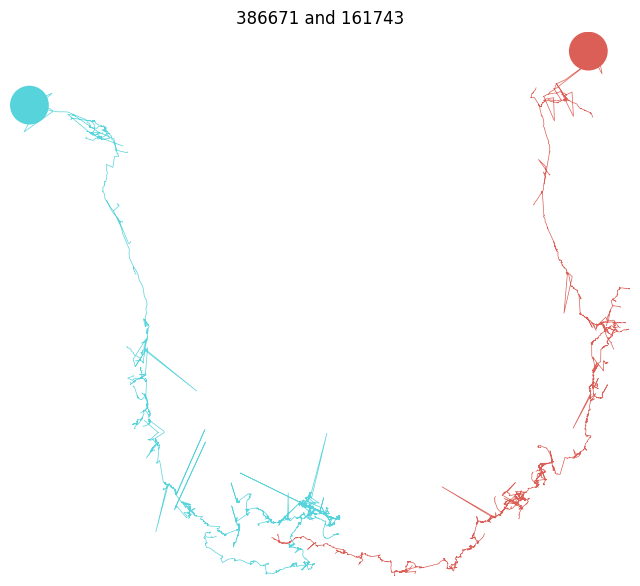

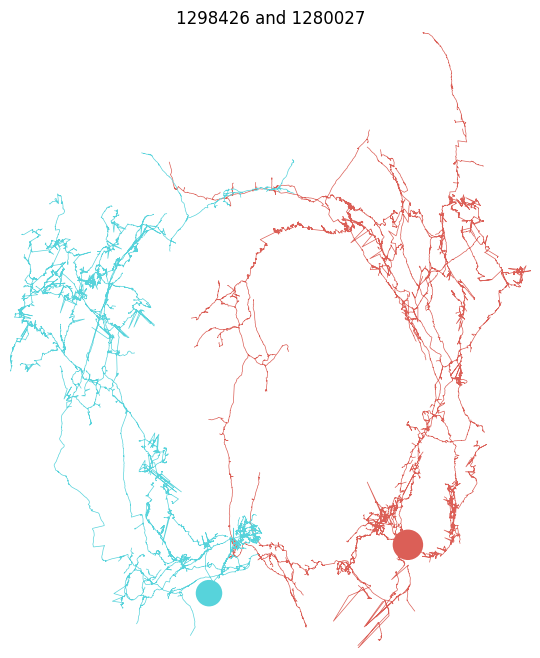

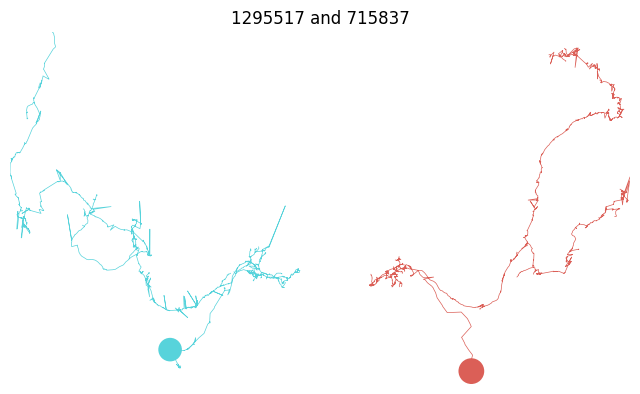

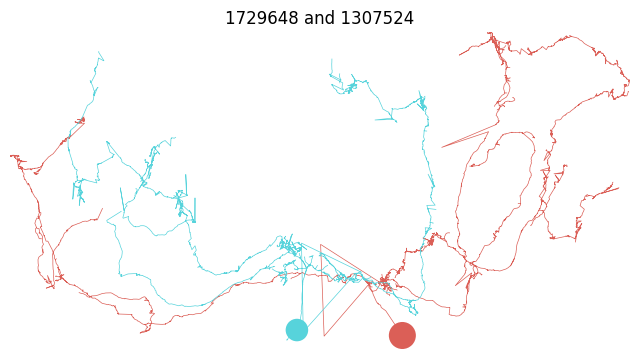

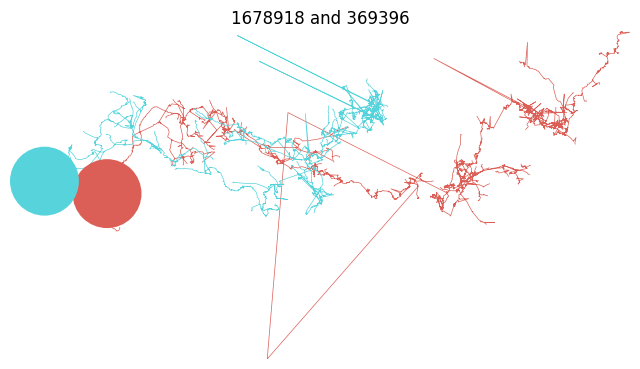

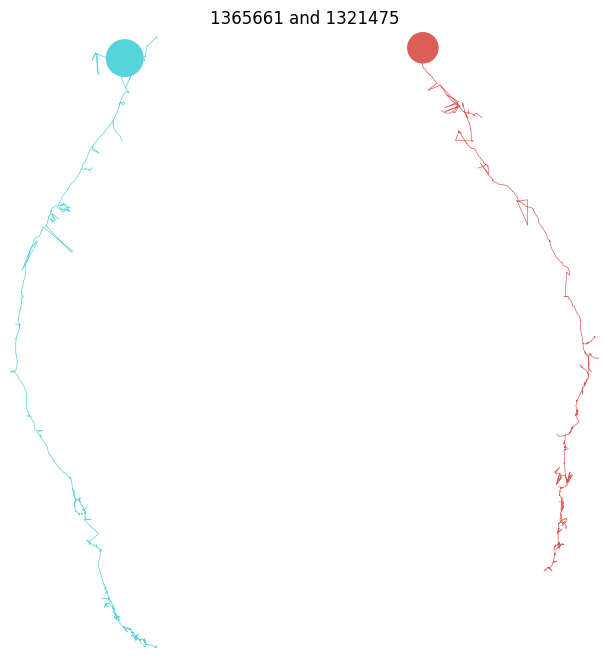

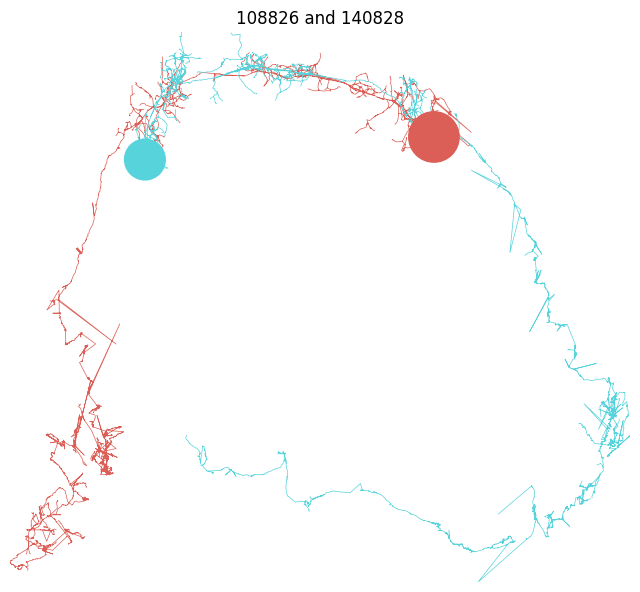

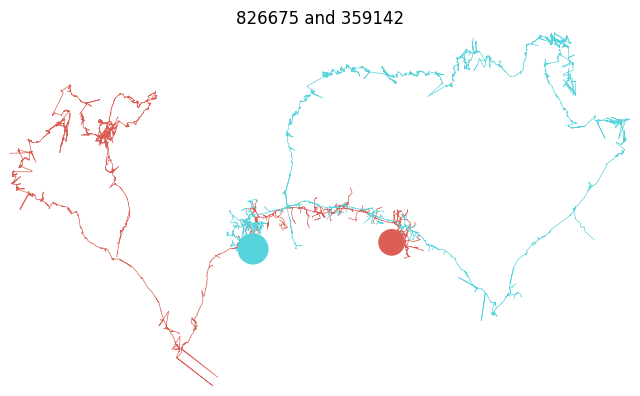

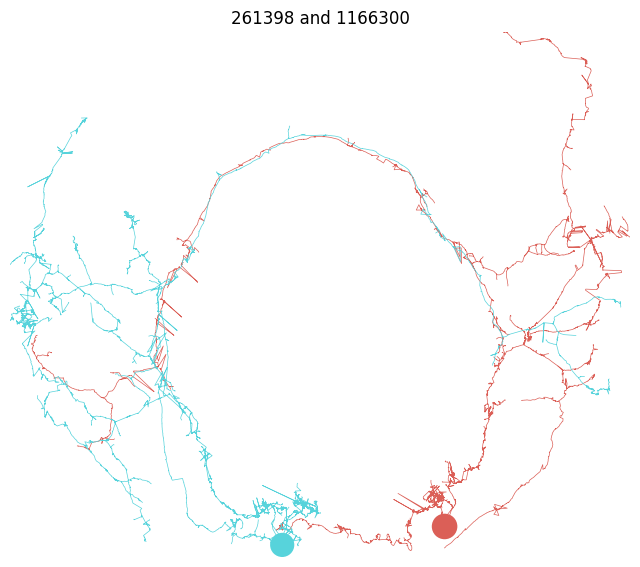

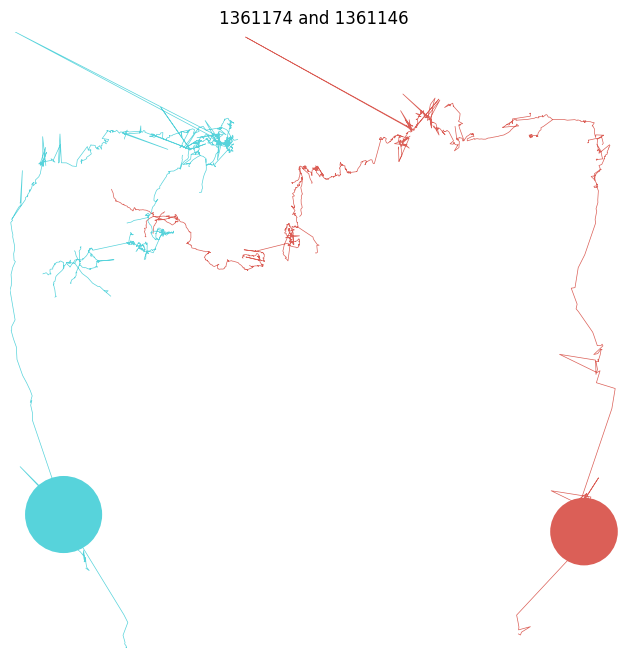

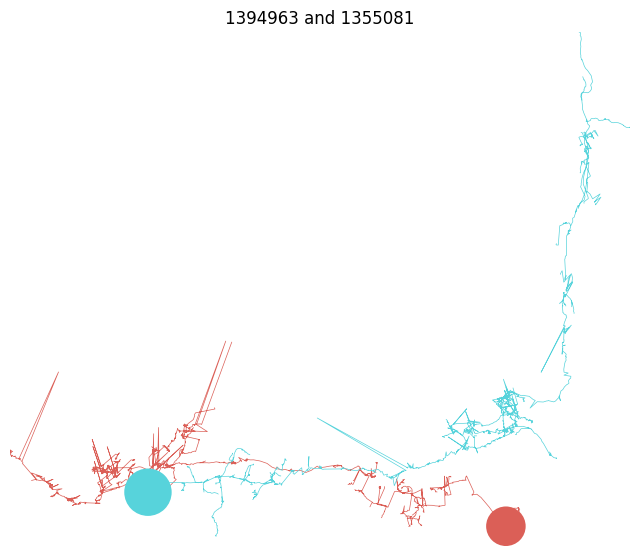

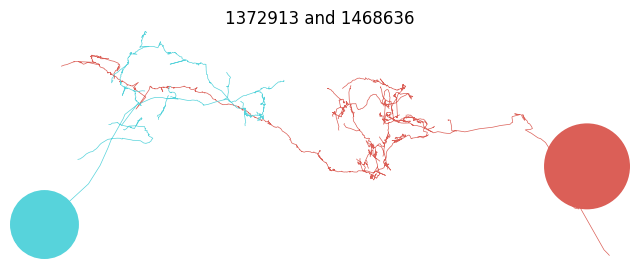

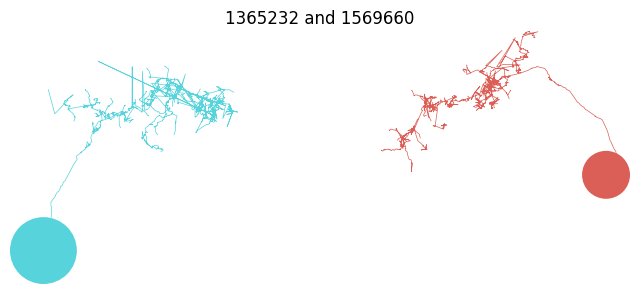

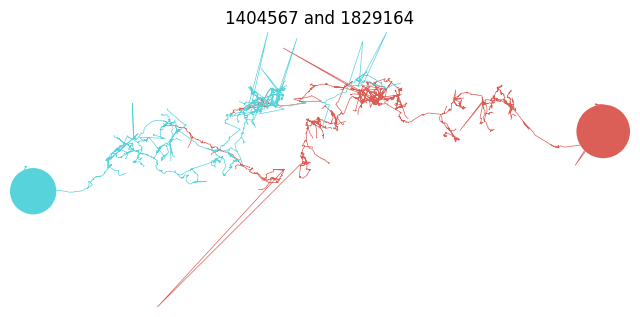

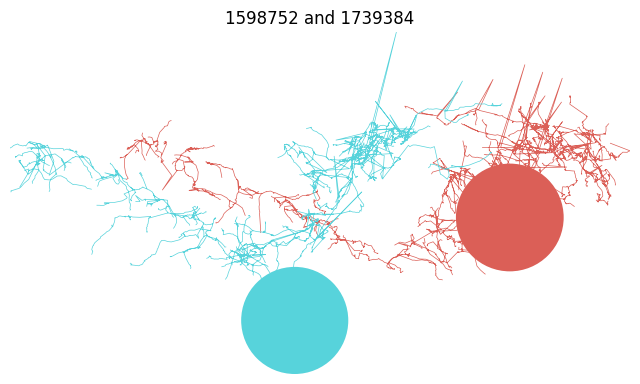

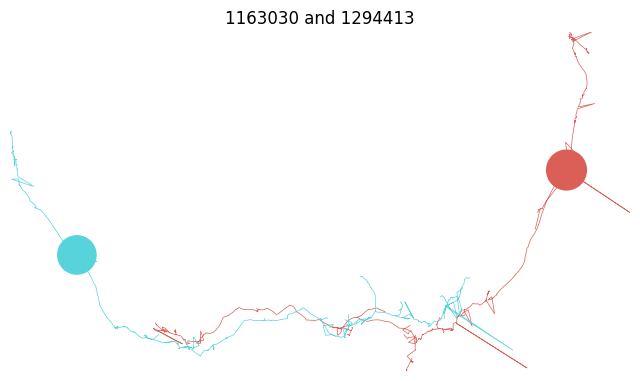

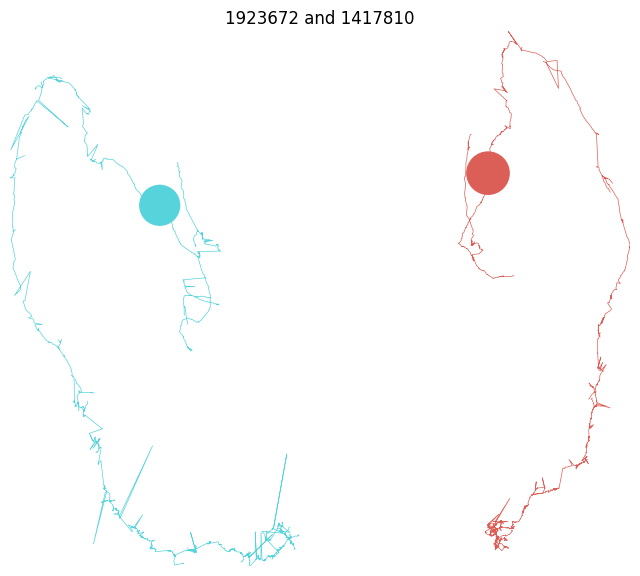

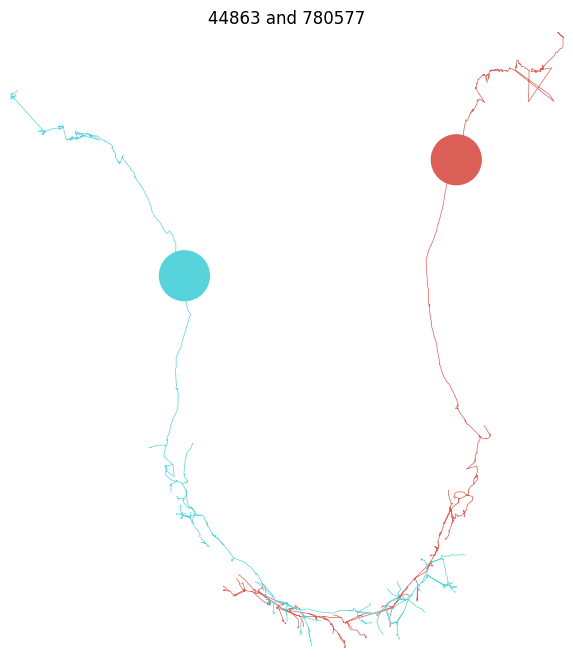

In [234]:
for i in range(len(neuron_list)):
    fig, ax = navis.plot2d(neuron_list[i], method='2d', view=('x', '-y'))
    left = correct_sub_df.loc[i, "skid-ID LEFT"]
    right = correct_sub_df.loc[i, "skid-ID RIGHT"]
    ax.set_title(f"{left} and {right}")

Take the norm of our subgraphs from graph matching

In [235]:
#norms of matched adjs
#subset and permute the adjacencies by their indices from matching
sub_matched_norm_list = []
for i in range(n_iters):
    np_sub_left_adj_matched = np_sub_left_adj[np.ix_(sub_ind_left_list[i], sub_ind_left_list[i])]
    np_sub_right_adj_matched = np_sub_right_adj[np.ix_(sub_ind_right_list[i], sub_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_diff_adj_matched = np_sub_left_adj_matched - np_sub_right_adj_matched
    sub_diff_matched_norm = np.linalg.norm(np_sub_diff_adj_matched)
    sub_matched_norm_list.append(sub_diff_matched_norm)
    #print(f"Norm of difference of left and right matched adjs: {sub_diff_matched_norm}")

In [236]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_left_adj_rand = np_sub_left_adj[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj), size=len(np_sub_right_adj), replace=False)
    np_sub_right_adj_rand = np_sub_right_adj[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_diff_adj_rand = np_sub_left_adj_rand - np_sub_right_adj_rand
    sub_diff_rand_norm = np.linalg.norm(np_sub_diff_adj_rand)
    rand_norms.append(sub_diff_rand_norm)

#print(f"Norm of difference of left and right randomly permuted adjs: {sub_diff_rand_norm}")

In [237]:
sub_matched_norm_average = np.average(sub_matched_norm_list)
sub_matched_accuracy_average = np.average(sub_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of matched vs random sub adjacencies (norm: 73.66), (accuracy: 0.07)')

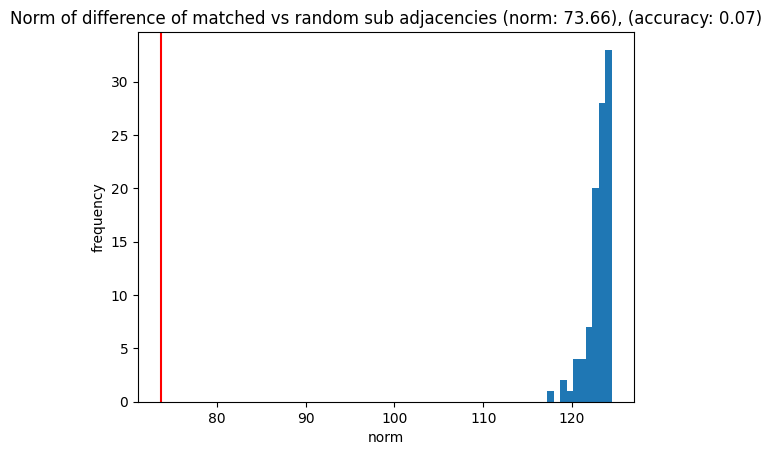

In [238]:
#histogram
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms)
ax.axvline(sub_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average))

Do the initialization on the whole graph

In [239]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
whole_left_skids_in_pairs = []
whole_right_skids_in_pairs = []

#iterate through Nadine's list
for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in right_skids):
        whole_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        whole_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [240]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
whole_left_skids_not_pairs = np.array([skid for skid in left_skids if skid not in whole_left_skids_in_pairs])
whole_right_skids_not_pairs = np.array([skid for skid in right_skids if skid not in whole_right_skids_in_pairs])

whole_left_skids_not_pairs_rand_list = []
whole_right_skids_not_pairs_rand_list = []

#shuffle the lists n_iters times
for i in range(n_iters):
    rand_ind_left = rng.choice(len(whole_left_skids_not_pairs), size=len(whole_left_skids_not_pairs), replace=False)
    whole_left_skids_not_pairs_rand = whole_left_skids_not_pairs[rand_ind_left]
    whole_left_skids_not_pairs_rand_list.append(whole_left_skids_not_pairs_rand)

    rand_ind_right = rng.choice(len(whole_right_skids_not_pairs), size=len(whole_right_skids_not_pairs), replace=False)
    whole_right_skids_not_pairs_rand = whole_right_skids_not_pairs[rand_ind_right]
    whole_right_skids_not_pairs_rand_list.append(whole_right_skids_not_pairs_rand)

In [241]:
#concatenate the pairs and not pairs lists
whole_left_skids_to_match_list = []
whole_right_skids_to_match_list = []
whole_nadine_pairs_list = []
for i in range(n_iters):
    whole_left_skids_to_match = np.append(whole_left_skids_in_pairs, whole_left_skids_not_pairs_rand_list[i], axis=0)
    whole_left_skids_to_match_list.append(whole_left_skids_to_match)

    whole_right_skids_to_match = np.append(whole_right_skids_in_pairs, whole_right_skids_not_pairs_rand_list[i], axis=0)
    whole_right_skids_to_match_list.append(whole_right_skids_to_match)

    whole_nadine_pairs = pd.DataFrame(list(zip(whole_left_skids_to_match, whole_right_skids_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_pairs_list.append(whole_nadine_pairs)

In [242]:
true_pairs

,index,skid-ID LEFT,skid-ID RIGHT
0,0,7501,25010
1,1,10536,26163
2,2,6743,23921
3,3,151847,27064
4,4,12115,27917
...,...,...,...
288,669,1326008,1359694
289,670,1717565,1330831
290,671,493317,1299058
291,672,1855933,111948


Calculate the norm and accuracy of the initialized skids before graph matching

In [243]:
#WHOLE, NADINE, NADINE
whole_to_match_accuracy_list = []

for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_df = pd.merge(true_pairs, whole_nadine_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_df[whole_nadine_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_df[whole_nadine_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_to_match_accuracy = num/den
    whole_to_match_accuracy_list.append(whole_to_match_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))
    print(den)

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.875
280
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.8781362007168458
279
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.875
280
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.875
280
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.8844765342960289
277
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.875
280
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.8781362007168458
279
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.875
280
The proportion of left right pairs from graph matching that correctly match with the true

In [244]:
#norms of whole nadine init adjs
diff_whole_to_match_norm_list = []
np_whole_left_adj_to_match_list = []
np_whole_left_adj_to_match_trunc_list = []
np_whole_right_adj_to_match_list = []

for i in range(n_iters):
    #chop the last skids of the left skid list so the dimensions match
    whole_left_skids_to_match_trunc = whole_left_skids_to_match_list[i][0:len(whole_right_skids_to_match_list[i])]

    #make adjs
    whole_left_adj_to_match = pymaid.adjacency_matrix(whole_left_skids_to_match_list[i])
    whole_left_adj_to_match_trunc = pymaid.adjacency_matrix(whole_left_skids_to_match_trunc)
    whole_right_adj_to_match = pymaid.adjacency_matrix(whole_right_skids_to_match_list[i])

    np_whole_left_adj_to_match = np.array(whole_left_adj_to_match)
    np_whole_left_adj_to_match_trunc = np.array(whole_left_adj_to_match_trunc)
    np_whole_right_adj_to_match = np.array(whole_right_adj_to_match)

    np_whole_left_adj_to_match_list.append(np_whole_left_adj_to_match)
    np_whole_left_adj_to_match_trunc_list.append(np_whole_left_adj_to_match_trunc)
    np_whole_right_adj_to_match_list.append(np_whole_right_adj_to_match)

    #calculate norm of difference of matched adjacencies
    np_diff_whole_nadine = np_whole_left_adj_to_match_trunc - np_whole_right_adj_to_match
    diff_whole_to_match_norm = np.linalg.norm(np_diff_whole_nadine)
    diff_whole_to_match_norm_list.append(diff_whole_to_match_norm)

    print(f"Norm of difference of left and right matched adjs: {diff_whole_to_match_norm}")

Norm of difference of left and right matched adjs: 208.65282169191963
Norm of difference of left and right matched adjs: 208.0048076367467
Norm of difference of left and right matched adjs: 209.23670806051217
Norm of difference of left and right matched adjs: 209.0908893280623
Norm of difference of left and right matched adjs: 209.97618912629116
Norm of difference of left and right matched adjs: 208.5665361461421
Norm of difference of left and right matched adjs: 208.3098653448751
Norm of difference of left and right matched adjs: 207.99038439312525
Norm of difference of left and right matched adjs: 207.85571919001893
Norm of difference of left and right matched adjs: 209.72124355915878
Norm of difference of left and right matched adjs: 210.41150158677164
Norm of difference of left and right matched adjs: 209.84279830387317
Norm of difference of left and right matched adjs: 209.5519028784993
Norm of difference of left and right matched adjs: 208.5209821576716
Norm of difference of left

In [245]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):

    #randomly subset the truncated left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match_trunc), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_nadine_left_adj_rand = np_whole_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_nadine_right_adj_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_nadine_left_adj_rand - np_whole_nadine_right_adj_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [246]:
diff_whole_to_match_norm_average = np.average(diff_whole_to_match_norm_list)
whole_to_match_accuracy_average = np.average(whole_to_match_accuracy)

Text(0.5, 1.0, 'Norm of difference of initialized vs random whole adjacencies (norm: 208.78), (accuracy: 0.88)')

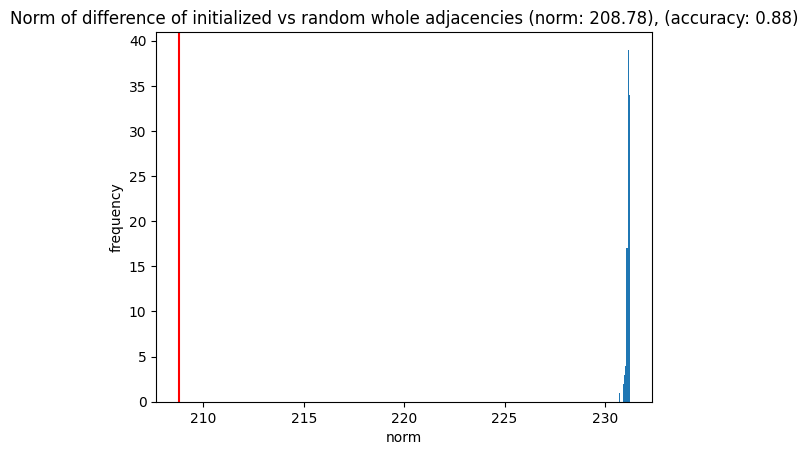

In [247]:
#histogram for WHOLE, NADINE, NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(diff_whole_to_match_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average))

In [248]:
whole_nadine_ind_left_list = []
whole_nadine_ind_right_list = []

#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
perm_mat = np.eye(max(len(whole_left_skids_to_match), len(whole_right_skids_to_match)))

In [249]:
#graph match with initialization on whole graph
for i in range(n_iters):
    whole_nadine_ind_left, whole_nadine_ind_right, whole_score_align, _ = graph_match(np_whole_left_adj_to_match, np_whole_right_adj_to_match, init=perm_mat)
    whole_nadine_ind_left_list.append(whole_nadine_ind_left)
    whole_nadine_ind_right_list.append(whole_nadine_ind_right)

In [250]:
whole_score_align

16194.0

In [251]:
whole_nadine_matched_pairs_list = []
for i in range(n_iters):
    whole_skids_left_form_matched = whole_left_skids_to_match[whole_nadine_ind_left_list[i]]
    whole_skids_right_form_matched = whole_right_skids_to_match[whole_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    whole_nadine_matched_pairs = pd.DataFrame(list(zip(whole_skids_left_form_matched, whole_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    whole_nadine_matched_pairs_list.append(whole_nadine_matched_pairs)

In [252]:
#WHOLE, NADINE, OPT
whole_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    whole_nadine_matched_df = pd.merge(true_pairs, whole_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = whole_nadine_matched_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = whole_nadine_matched_df[whole_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    whole_nadine_matched_accuracy = num/den
    whole_nadine_matched_accuracy_list.append(whole_nadine_matched_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2440318302387268
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.23697916666666666
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2647058823529412
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.22631578947368422
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2553763440860215
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.2413793103448276
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.24538258575197888
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.24324324324324326
The proportion of left right pairs from graph matchi

In [253]:
#norms of whole init opt adjs
whole_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_whole_nadine_matched_left_adj = np_whole_left_adj_to_match[np.ix_(whole_nadine_ind_left_list[i], whole_nadine_ind_left_list[i])]
    np_whole_nadine_matched_right_adj = np_whole_right_adj_to_match[np.ix_(whole_nadine_ind_right_list[i], whole_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_whole_nadine_matched_diff = np_whole_nadine_matched_left_adj - np_whole_nadine_matched_right_adj
    diff_whole_nadine_matched_norm = np.linalg.norm(np_whole_nadine_matched_diff)
    whole_nadine_matched_norm_list.append(diff_whole_nadine_matched_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_whole_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 145.96917482811224
Norm of difference of left and right matched adjs: 145.5300656221937
Norm of difference of left and right matched adjs: 146.24636747625564
Norm of difference of left and right matched adjs: 146.25320509308506
Norm of difference of left and right matched adjs: 146.82642813880614
Norm of difference of left and right matched adjs: 145.53693689232298
Norm of difference of left and right matched adjs: 145.3168950948237
Norm of difference of left and right matched adjs: 146.52303573158727
Norm of difference of left and right matched adjs: 146.05136082899057
Norm of difference of left and right matched adjs: 146.3659796537433
Norm of difference of left and right matched adjs: 146.3488981851247
Norm of difference of left and right matched adjs: 145.8800877433243
Norm of difference of left and right matched adjs: 146.08559134972896
Norm of difference of left and right matched adjs: 146.37281168304446
Norm of difference of lef

In [254]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_whole_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_whole_left_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_left_adj_to_match_rand = np_whole_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_whole_right_adj_to_match), size=len(np_whole_right_adj_to_match), replace=False)
    np_whole_right_adj_to_match_rand = np_whole_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_whole_nadine_diff_adj_rand = np_whole_left_adj_to_match_rand - np_whole_right_adj_to_match_rand
    diff_whole_nadine_rand_norm = np.linalg.norm(np_whole_nadine_diff_adj_rand)
    rand_norms_whole_nadine.append(diff_whole_nadine_rand_norm)

In [255]:
whole_nadine_matched_norm_average = np.average(whole_nadine_matched_norm_list)
whole_nadine_matched_accuracy_average = np.average(whole_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random whole adjacencies (norm: 145.95), (accuracy: 0.24)')

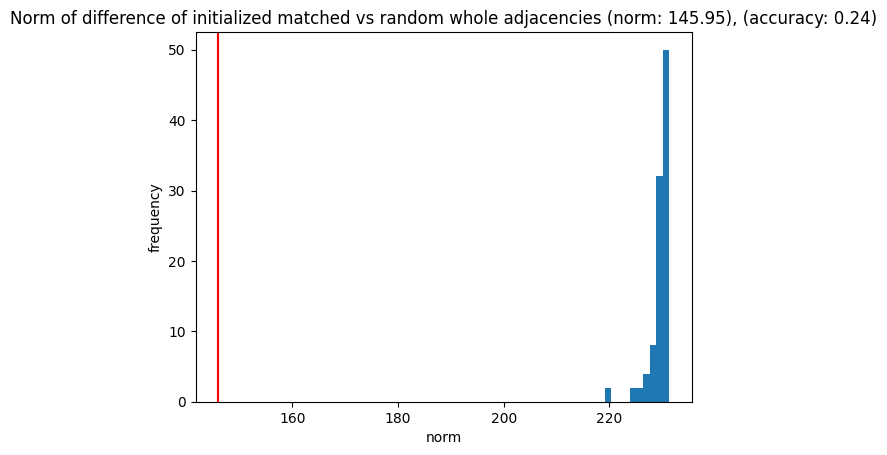

In [256]:
#histogram of WHOLE NADINE OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_whole_nadine)
ax.axvline(whole_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random whole adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average))

Now we do the same initialization but on the subgraph of the left and right neurons

In [257]:
#these are the lists of the skids that are paired in Nadine's lists, and both of the skids in the pair exist in our left and right lists respectively
sub_left_skids_in_pairs = []
sub_right_skids_in_pairs = []

for i in range(len(true_pairs)):
    if (true_pairs.loc[i, "skid-ID LEFT"] in sub_left_skids and true_pairs.loc[i, "skid-ID RIGHT"] in sub_right_skids):
        sub_left_skids_in_pairs.append(true_pairs.loc[i, "skid-ID LEFT"])
        sub_right_skids_in_pairs.append(true_pairs.loc[i, "skid-ID RIGHT"])

In [258]:
#get the list of skids in our left and right skids that are not in the lists we just made and shuffle them
sub_left_skids_not_pairs = np.array([skid for skid in sub_left_skids if skid not in sub_left_skids_in_pairs])
sub_right_skids_not_pairs = np.array([skid for skid in sub_right_skids if skid not in sub_right_skids_in_pairs])

sub_left_skids_not_pairs_rand_list = []
sub_right_skids_not_pairs_rand_list = []

#shuffle the lists n_iters times
for i in range(n_iters):
    rand_ind_left = rng.choice(len(sub_left_skids_not_pairs), size=len(sub_left_skids_not_pairs), replace=False)
    sub_left_skids_not_pairs_rand = sub_left_skids_not_pairs[rand_ind_left]
    sub_left_skids_not_pairs_rand_list.append(sub_left_skids_not_pairs_rand)

    rand_ind_right = rng.choice(len(sub_right_skids_not_pairs), size=len(sub_right_skids_not_pairs), replace=False)
    sub_right_skids_not_pairs_rand = sub_right_skids_not_pairs[rand_ind_right]
    sub_right_skids_not_pairs_rand_list.append(sub_right_skids_not_pairs_rand)

In [259]:
#concatenate the pairs and not pairs lists
sub_left_skids_to_match_list = []
sub_right_skids_to_match_list = []
sub_nadine_pairs_list = []

for i in range(n_iters):
    sub_left_skids_to_match = np.append(sub_left_skids_in_pairs, sub_left_skids_not_pairs_rand_list[i], axis=0)
    sub_left_skids_to_match_list.append(sub_left_skids_to_match)

    sub_right_skids_to_match = np.append(sub_right_skids_in_pairs, sub_right_skids_not_pairs_rand_list[i], axis=0)
    sub_right_skids_to_match_list.append(sub_right_skids_to_match)

    sub_nadine_pairs = pd.DataFrame(list(zip(sub_left_skids_to_match, sub_right_skids_to_match)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_pairs_list.append(sub_nadine_pairs)

In [260]:
#SUB, NADINE, NADINE
sub_to_match_accuracy_list = []

for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_df = pd.merge(true_pairs, sub_nadine_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_df["Exist"].value_counts()["both"]

    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_df[sub_nadine_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_df[sub_nadine_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_to_match_accuracy = num/den
    sub_to_match_accuracy_list.append(sub_to_match_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9459459459459459
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9459459459459459
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9459459459459459
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9459459459459459
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9459459459459459
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9459459459459459
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9459459459459459
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.9459459459459459
The proportion of left right pairs from graph matching t

In [261]:
#norms of sub nadine init adjs
diff_sub_to_match_norm_list = []
np_sub_left_adj_to_match_list = []
np_sub_left_adj_to_match_trunc_list = []
np_sub_right_adj_to_match_list = []

for i in range(n_iters):
    #chop the last skids of the left skid list so the dimensions match
    sub_left_skids_to_match_trunc = sub_left_skids_to_match_list[i][0:len(sub_right_skids_to_match_list[i])]

    #make adjs
    sub_left_adj_to_match = pymaid.adjacency_matrix(sub_left_skids_to_match_list[i])
    sub_left_adj_to_match_trunc = pymaid.adjacency_matrix(sub_left_skids_to_match_trunc)
    sub_right_adj_to_match = pymaid.adjacency_matrix(sub_right_skids_to_match_list[i])

    np_sub_left_adj_to_match = np.array(sub_left_adj_to_match)
    np_sub_left_adj_to_match_trunc = np.array(sub_left_adj_to_match_trunc)
    np_sub_right_adj_to_match = np.array(sub_right_adj_to_match)

    np_sub_left_adj_to_match_list.append(np_sub_left_adj_to_match)
    np_sub_left_adj_to_match_trunc_list.append(np_sub_left_adj_to_match_trunc)
    np_sub_right_adj_to_match_list.append(np_sub_right_adj_to_match)

    #calculate norm of difference of matched adjacencies
    np_diff_sub_nadine = np_sub_left_adj_to_match_trunc - np_sub_right_adj_to_match
    diff_sub_to_match_norm = np.linalg.norm(np_diff_sub_nadine)
    diff_sub_to_match_norm_list.append(diff_sub_to_match_norm)

    print(f"Norm of difference of left and right matched adjs: {diff_sub_to_match_norm}")

Norm of difference of left and right matched adjs: 79.35993951610598
Norm of difference of left and right matched adjs: 79.39143530633515
Norm of difference of left and right matched adjs: 79.3473376995095
Norm of difference of left and right matched adjs: 78.91134265744057
Norm of difference of left and right matched adjs: 78.93668348746354
Norm of difference of left and right matched adjs: 77.12976079309465
Norm of difference of left and right matched adjs: 76.64202502543888
Norm of difference of left and right matched adjs: 79.20858539325141
Norm of difference of left and right matched adjs: 75.65712127751095
Norm of difference of left and right matched adjs: 79.31582439841371
Norm of difference of left and right matched adjs: 75.66372975210778
Norm of difference of left and right matched adjs: 79.86238163240563
Norm of difference of left and right matched adjs: 79.45438943192504
Norm of difference of left and right matched adjs: 78.88599368709251
Norm of difference of left and righ

In [262]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match_trunc), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_left_adj_rand = np_sub_left_adj_to_match_trunc[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_nadine_right_adj_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_nadine_left_adj_rand - np_sub_nadine_right_adj_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [263]:
diff_sub_to_match_norm_average = np.average(diff_sub_to_match_norm_list)
sub_to_match_accuracy_average = np.average(sub_to_match_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized vs random sub adjacencies (norm: 78.25), (accuracy: 0.95)')

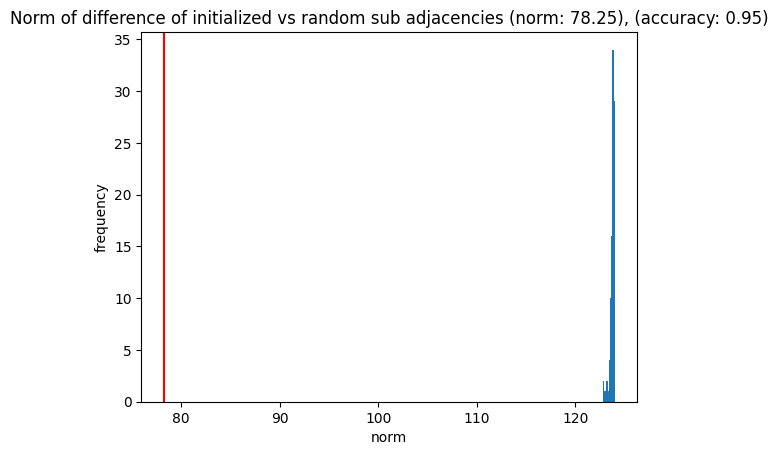

In [264]:
#histogram of WHOLE NADINE NADINE
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(diff_sub_to_match_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average))

In [265]:
sub_nadine_ind_left_list = []
sub_nadine_ind_right_list = []

#make identity matrix that is the size of the bigger matrix as the permutation matrix to initialize graph matching
sub_perm_mat = np.eye(max(len(sub_left_skids_to_match), len(sub_right_skids_to_match)))

In [266]:
#graph match with initialization on subgraphs
for i in range(n_iters):
    sub_nadine_ind_left, sub_nadine_ind_right, sub_score_align, _ = graph_match(np_sub_left_adj_to_match, np_sub_right_adj_to_match, init=sub_perm_mat)
    sub_nadine_ind_left_list.append(sub_nadine_ind_left)
    sub_nadine_ind_right_list.append(sub_nadine_ind_right)

In [267]:
sub_score_align

5410.0

In [268]:
sub_nadine_matched_pairs_list = []
for i in range(n_iters):
    sub_skids_left_form_matched = sub_left_skids_to_match[sub_nadine_ind_left_list[i]]
    sub_skids_right_form_matched = sub_right_skids_to_match[sub_nadine_ind_right_list[i]]

    #make dataframe for the matched pairs
    sub_nadine_matched_pairs = pd.DataFrame(list(zip(sub_skids_left_form_matched, sub_skids_right_form_matched)), columns = ["skid-ID LEFT", "skid-ID RIGHT"])
    sub_nadine_matched_pairs_list.append(sub_nadine_matched_pairs)

In [269]:
#SUB, NADINE, OPT
sub_nadine_matched_accuracy_list = []
for i in range(n_iters):
    #merge the true pairs and our matched pairs by their union
    sub_nadine_matched_df = pd.merge(true_pairs, sub_nadine_matched_pairs_list[i], on=['skid-ID LEFT','skid-ID RIGHT'], how="outer", indicator='Exist')

    #the numerator of the accuracy is the number of rows where the "Exist" column = "both" (when a pair from our graph matching correctly corresponds to nadine's list)
    num = sub_nadine_matched_df["Exist"].value_counts()["both"]
    #to get the denominator, need to find the number of rows where there is a duplicate in either the left column or the right column or both
    duplicate_L = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID LEFT")]
    duplicate_R = sub_nadine_matched_df[sub_nadine_matched_df.duplicated("skid-ID RIGHT")]

    #take the union of the two duplicated dfs to get rid of any repeated rows among the two dfs
    #repeats happen when graph matching incorrectly matches two neurons, but both of those neurons appear in nadine's list in different pairs
    duplicate_df = pd.merge(duplicate_L, duplicate_R, on=["skid-ID LEFT", 'skid-ID RIGHT'], how="outer")

    #the denominator of the accuracy is the number of rows of duplicate_df plus the number of correct matched pairs
    den = len(duplicate_df) + num
    sub_nadine_matched_accuracy = num/den
    sub_nadine_matched_accuracy_list.append(sub_nadine_matched_accuracy)
    print("The proportion of left right pairs from graph matching that correctly match with the true pairs is {}".format(num/den))

The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.38996138996138996
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.38223938223938225
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.3667953667953668
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.38996138996138996
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.3783783783783784
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.3783783783783784
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.3861003861003861
The proportion of left right pairs from graph matching that correctly match with the true pairs is 0.3745173745173745
The proportion of left right pairs from graph matchin

In [270]:
#norms of sub init opt adjs
sub_nadine_matched_norm_list = []
for i in range(n_iters):
    #subset and permute the adjacencies by their indices from matching
    np_sub_nadine_matched_left_adj = np_sub_left_adj_to_match[np.ix_(sub_nadine_ind_left_list[i], sub_nadine_ind_left_list[i])]
    np_sub_nadine_matched_right_adj = np_sub_right_adj_to_match[np.ix_(sub_nadine_ind_right_list[i], sub_nadine_ind_right_list[i])]

    #calculate norm of difference of matched adjacencies
    np_sub_nadine_matched_diff = np_sub_nadine_matched_left_adj - np_sub_nadine_matched_right_adj
    diff_sub_nadine_matched_norm = np.linalg.norm(np_sub_nadine_matched_diff)
    sub_nadine_matched_norm_list.append(diff_sub_nadine_matched_norm)
    print(f"Norm of difference of left and right matched adjs: {diff_sub_nadine_matched_norm}")

Norm of difference of left and right matched adjs: 68.51277253184256
Norm of difference of left and right matched adjs: 68.54925236645546
Norm of difference of left and right matched adjs: 68.58571279792899
Norm of difference of left and right matched adjs: 68.62215385719105
Norm of difference of left and right matched adjs: 68.52736679604726
Norm of difference of left and right matched adjs: 68.7386354243376
Norm of difference of left and right matched adjs: 68.65129277733959
Norm of difference of left and right matched adjs: 68.51277253184256
Norm of difference of left and right matched adjs: 68.78953408767936
Norm of difference of left and right matched adjs: 68.67313885355759
Norm of difference of left and right matched adjs: 68.5054742338158
Norm of difference of left and right matched adjs: 68.76772498781678
Norm of difference of left and right matched adjs: 68.62215385719105
Norm of difference of left and right matched adjs: 68.71681017043792
Norm of difference of left and right

In [271]:
#norms of randomly permuted adjs
from numpy.random import default_rng

rand_norms_sub_nadine = []
rng = default_rng()

#do 100 times to make histogram
for _ in range(n_iters_rand):
    
    #randomly subset the left adj
    rand_ind_left = rng.choice(len(np_sub_left_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_left_adj_to_match_rand = np_sub_left_adj_to_match[np.ix_(rand_ind_left, rand_ind_left)]

    #randomly permute the right adj
    rand_ind_right = rng.choice(len(np_sub_right_adj_to_match), size=len(np_sub_right_adj_to_match), replace=False)
    np_sub_right_adj_to_match_rand = np_sub_right_adj_to_match[np.ix_(rand_ind_right, rand_ind_right)]

    #calculate norm of difference of random adjacencies›
    np_sub_nadine_diff_adj_rand = np_sub_left_adj_to_match_rand - np_sub_right_adj_to_match_rand
    diff_sub_nadine_rand_norm = np.linalg.norm(np_sub_nadine_diff_adj_rand)
    rand_norms_sub_nadine.append(diff_sub_nadine_rand_norm)

In [272]:
sub_nadine_matched_norm_average = np.average(sub_nadine_matched_norm_list)
sub_nadine_matched_accuracy_average = np.average(sub_nadine_matched_accuracy_list)

Text(0.5, 1.0, 'Norm of difference of initialized matched vs random sub adjacencies (norm: 68.67), (accuracy: 0.38)')

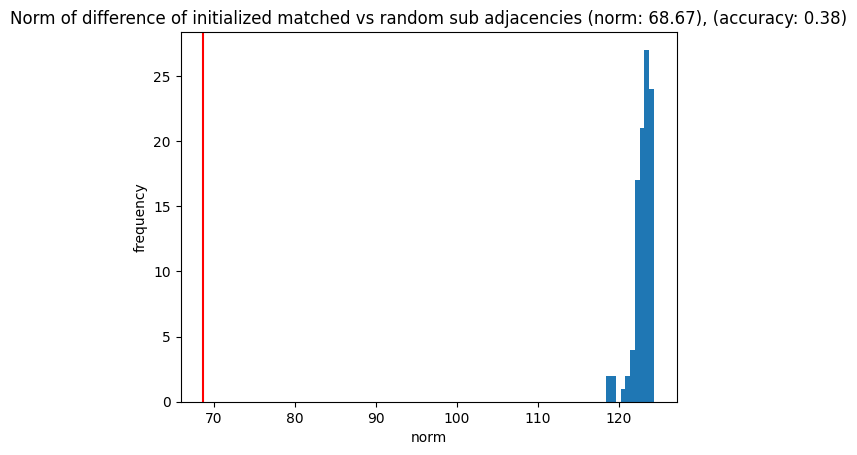

In [273]:
#histogram of SUB INIT OPT
fig, ax = plt.subplots(1, 1)
ax.hist(rand_norms_sub_nadine)
ax.axvline(sub_nadine_matched_norm_average, color="r")
ax.set_xlabel("norm")
ax.set_ylabel("frequency")
ax.set_title("Norm of difference of initialized matched vs random sub adjacencies (norm: {:.2f}), (accuracy: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average))

Text(0.5, 1.0, 'Initialized Matched vs Random (Norm: 145.95), (Acc: 0.24)')

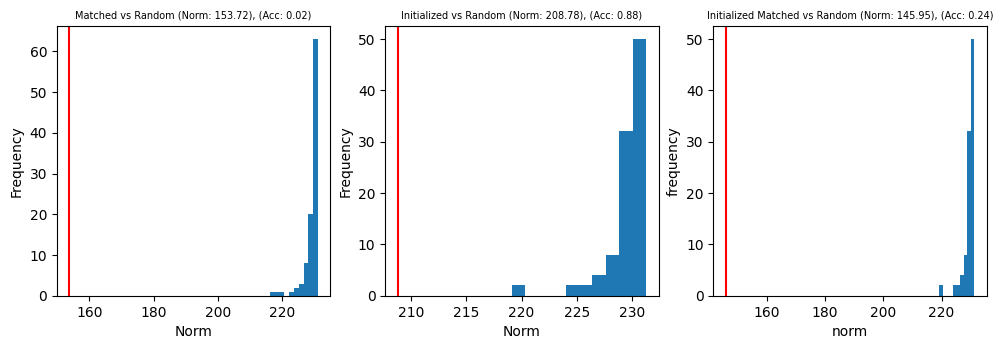

In [274]:
#whole histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

axes[0].hist(rand_norms_whole)
axes[0].axvline(norm_mean, color="r")
axes[0].set_xlabel("Norm")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Matched vs Random (Norm: {:.2f}), (Acc: {:.2f})".format(norm_mean, accuracy_mean), fontsize=7)

axes[1].hist(rand_norms_whole_nadine)
axes[1].axvline(diff_whole_to_match_norm_average, color="r")
axes[1].set_xlabel("Norm")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Initialized vs Random (Norm: {:.2f}), (Acc: {:.2f})".format(diff_whole_to_match_norm_average, whole_to_match_accuracy_average), fontsize=7)

axes[2].hist(rand_norms_whole_nadine)
axes[2].axvline(whole_nadine_matched_norm_average, color="r")
axes[2].set_xlabel("norm")
axes[2].set_ylabel("frequency")
axes[2].set_title("Initialized Matched vs Random (Norm: {:.2f}), (Acc: {:.2f})".format(whole_nadine_matched_norm_average, whole_nadine_matched_accuracy_average), fontsize=7)

Text(0.5, 1.0, 'Initialized Matched vs Random (Norm: 68.67), (Acc: 0.38)')

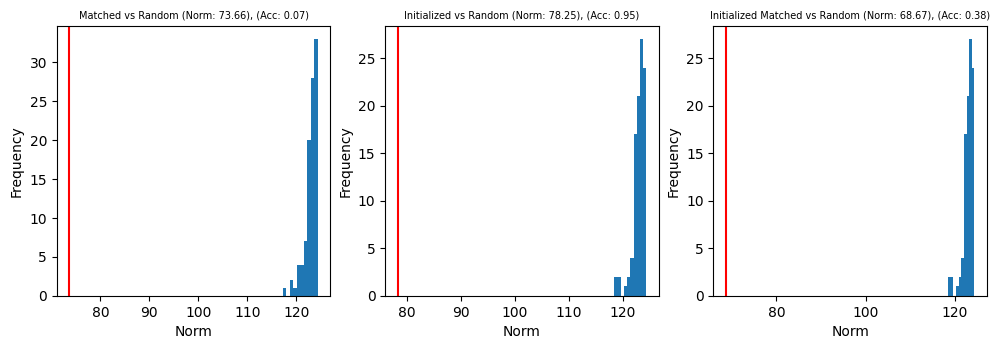

In [275]:
#sub histograms
fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))

axes[0].hist(rand_norms)
axes[0].axvline(sub_matched_norm_average, color="r")
axes[0].set_xlabel("Norm")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Matched vs Random (Norm: {:.2f}), (Acc: {:.2f})".format(sub_matched_norm_average, sub_matched_accuracy_average), fontsize=7)

axes[1].hist(rand_norms_sub_nadine)
axes[1].axvline(diff_sub_to_match_norm_average, color="r")
axes[1].set_xlabel("Norm")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Initialized vs Random (Norm: {:.2f}), (Acc: {:.2f})".format(diff_sub_to_match_norm_average, sub_to_match_accuracy_average), fontsize=7)

axes[2].hist(rand_norms_sub_nadine)
axes[2].axvline(sub_nadine_matched_norm_average, color="r")
axes[2].set_xlabel("Norm")
axes[2].set_ylabel("Frequency")
axes[2].set_title("Initialized Matched vs Random (Norm: {:.2f}), (Acc: {:.2f})".format(sub_nadine_matched_norm_average, sub_nadine_matched_accuracy_average), fontsize=7)

- For the cases that I don't run graph matching, when calculating the norm, since the left and right skid list have different dimension, I chop off the last skids of the left list so the left and right lists are the same length and the pairs align
- What is labels in the paired test?